In [1]:
%matplotlib inline  

In [2]:
# system ----
import os
import sys
import matplotlib
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
snap0 = 84
model = "illustrisTNG"
 
# local ----
localPath = os.path.expanduser("~/")
simPath = os.path.expanduser(localPath+"_simulations/"+model+"/")
projPath = os.path.expanduser(localPath+"_projects/researchproject_005/")
sys.path.append(projPath+"modules")
import plot_parameters 

***

In [4]:
# Load Illustris TNG modules

# ---- simulation parameters 
if(model == "illustris"):
    params = {
         'h0'     : 0.704,
         'omegaM' : 0.2726,
         'omegaL' : 0.7274,
         'omegaB' : 0.0456,
         'omegaR' : 0.0000,
         'boxsize': 106.5
         }
elif(model == "illustrisTNG"):
     params = {
         'h0'     : 0.6774,
         'omegaM' : 0.3089,
         'omegaL' : 0.6911,
         'omegaB' : 0.0486,
         'omegaR' : 0.0000,
         'boxsize': 110.7
         }

# ---- cluster selection
from illustris_python import groupcat
fof_fields = ['Group_M_TopHat200',
              'Group_R_TopHat200',
              'GroupFirstSub',
              'GroupNsubs']
sub_fields = ['SubhaloMass',
              'SubhaloPos',
              'SubhaloLenType',
              'SubhaloMassType']
 
fof = groupcat.loadHalos(simPath+"TNG100_1/output",snap0,fields=fof_fields)
sub = groupcat.loadSubhalos(simPath+"TNG100_1/output",snap0, fields=sub_fields)
h0 = params['h0']

<div class="alert alert-block alert-info">
     <font size="6"> <b> Clusters in in Illustris TNG  </b> </font> 
</div>

* We select target halos with mass $M_{\rm vir} \sim 10^{13} M_{\odot}$
* We define <b>resolved</b> subhalos to <b>at least</b> 20 dark matter particles

With $N_{\rm dm}=20$ and $m_{\rm dm} = 7.5 \times 10^{6} M_{\odot}$, the resolved mass will be
\begin{align}
m_{\rm res} = N_{\rm dm}m_{\rm dm} \approx 1.5 \times 10^{8} M_{\odot}
\end{align}

<div class="alert alert-block alert-danger">
TNG100-1 can not resolve down to 20 DM particles based off of the hmf function... so let the resolved mass be $m_{\rm res} = 10^{9} M_{\odot}$, which is about 
</div>

\begin{align}
N_{\rm dm} \approx 133
\end{align}

Let us sample out the target halo samples

In [5]:
# ---- sample out a host halo
Mmin = 8.e+12
Mmax = 2.e+13
mask_ = (( fof['Group_M_TopHat200'] > Mmin*h0/1e+10 ) & ( fof['Group_M_TopHat200'] < Mmax*h0/1e+10 )).nonzero()[0]
mask = mask_[10]

#mask = mask[0]
idh = fof['GroupFirstSub'][mask]
Mhalo = fof['Group_M_TopHat200'][mask] * 1e+10/h0
Rhalo = fof['Group_R_TopHat200'][mask] / h0
nSubs = fof['GroupNsubs'][mask]
hpos = sub["SubhaloPos"][idh]
 
# ---- sample subhalos for prep
resPartNum = 20
min_mass = resPartNum * 7.5e+6
 
import cosmo
cosm = cosmo.Cosmology(**params)

smass_ = sub['SubhaloMass'][:] * 1e+10 / h0
spos_ = sub['SubhaloPos'][:]
slen_ = sub['SubhaloLenType'][:,1]
smass_ = np.delete(smass_,idh,0)
spos_ = np.delete(spos_,idh,0)
slen_ = np.delete(slen_,idh,0)
resolved_mass = ((smass_ > min_mass) & (slen_ >= 20))
smass = smass_[resolved_mass]
srvir = cosm.virial_radius(0.2,smass)
spos = spos_[resolved_mass]

***

***

***

<div class="alert alert-block alert-info">
     <font size="6"> <b> Projection of Clusters </b> </font> 
</div>

Now we will look at the sampling between several regions in a len-centered cylinder with radius $\mathcal{R} = R_{\rm vir}$ and lengths $\ell$

* $ 0 < \ell < R_{\rm vir}$ in (yellow-orange) 
* $ R_{\rm vir} < \ell < 2R_{\rm vir}$ in (red-pink) 
* $ 2R_{\rm vir} < \ell < L_{\rm box}$ in (violet) 



In [6]:
# ---- dimensions of our LOS cylinder
length_box = params['boxsize'] * 1000 # kpc
length_rvir = Rhalo
length_rvir2 = 2. * Rhalo
radius = Rhalo

# ---- begin analysis
a = cosm.scale_factor(0.2)
host_mass = Mhalo
host_pos = hpos * a/h0
sub_pos = spos * a/h0
dx = host_pos[0] - sub_pos[:,0]
dy = host_pos[1] - sub_pos[:,1]
dz = host_pos[2] - sub_pos[:,2]
 
Rxy = np.sqrt(np.power(dx,2) + np.power(dy,2))
Ryz = np.sqrt(np.power(dy,2) + np.power(dz,2))
Rzx = np.sqrt(np.power(dz,2) + np.power(dx,2))
 
LxRvir = (np.sqrt(np.power(dx,2)) < length_rvir/2.)
LxRvir2 = ((length_rvir/2. < np.sqrt(np.power(dx,2))) & (np.sqrt(np.power(dx,2)) < length_rvir2/2.))
LxBox = ((length_rvir2/2. < np.sqrt(np.power(dx,2))) & (np.sqrt(np.power(dx,2)) < length_box/2.))
Ly = np.sqrt(np.power(dy,2)) < length_box
Lz = np.sqrt(np.power(dz,2)) < length_box
 
# ---- sample inside virial radius
mask1x = ((LxRvir) & (Ryz < radius))
rad1x = srvir[mask1x]
pos1x_x = dx[mask1x]
pos1x_y = dy[mask1x]
pos1x_z = dz[mask1x]

# ---- sample inside [1-2] x virial raius
mask2x = ((LxRvir2) &  (Ryz < radius))
rad2x = srvir[mask2x]
pos2x_x = dx[mask2x]
pos2x_y = dy[mask2x]
pos2x_z = dz[mask2x]
 
# ---- sample 2 x Rvir to box length
mask3x = ((LxBox) & (Ryz < radius))
rad3x = srvir[mask3x]
pos3x_x = dx[mask3x]
pos3x_y = dy[mask3x]
pos3x_z = dz[mask3x]

### Let us now take a look at the face-on and edge LOS projections of this target cluster
#### Face-on

/usr/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


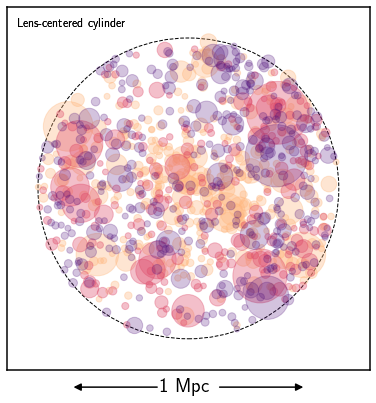

In [7]:
fig = plt.figure(figsize=(8/1.2,8/1.2))
ax = fig.add_subplot(111, aspect='equal')
 
cmap = matplotlib.cm.get_cmap('magma')
 
# ---- plot actual virial radius
circle1 = plt.Circle((0, 0), radius, color='black', fill=False, linestyle='--')
ax.add_artist(circle1)
 
# ---- plot subhalos within cylinder of virial radius at x-face LOS
for i in range(len(rad1x)):
    circleN = plt.Circle((pos1x_y[i], pos1x_z[i]), rad1x[i], color=cmap(0.85), alpha=0.35)
    ax.add_artist(circleN)
# ---- plot subhalos within cylinder of [1-2] times virial radius at x-face LOS
for i in range(len(rad2x)):
    circle2N = plt.Circle((pos2x_y[i], pos2x_z[i]), rad2x[i], color=cmap(0.6), alpha=0.35)
    ax.add_artist(circle2N) 
# ---- plot subhalos within cylinder of 2] times virial radius and box length x-face LOS
for i in range(len(rad3x)):
    circle3N = plt.Circle((pos3x_y[i], pos3x_z[i]), rad3x[i], color=cmap(0.25), alpha=0.25)
    ax.add_artist(circle3N)

# arrow outside box
ax.tick_params(axis=u'both', which=u'both', labelbottom='off', labelleft='off', length=0)
ax.set_xlim(-775,775)
ax.set_ylim(-775,775)
ax.text(-120, -870, '1 Mpc', fontsize=20)
ax.annotate('', xy=(-500, -850), xytext=(-125, -850), xycoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle="-|>", color='black', linewidth=1.5))
ax.annotate('', xy=(500, -850), xytext=(125, -850), xycoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle="-|>", color='black', linewidth=1.5))

 
# Additional text
from matplotlib.patches import Rectangle
empty = Rectangle((0,0), 0, 0, alpha=0.0)
label = ax.legend([empty],
         [r'Lens-centered cylinder'], loc="upper left", fontsize=12, frameon=False, handlelength=0, handletextpad=0)
label.get_texts()[0].set_color('black')
ax.add_artist(label)
plt.show()

#### Edge On

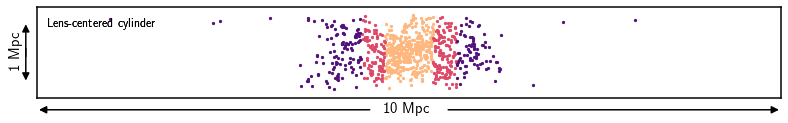

In [8]:
fig = plt.figure(figsize=(16/1.2,2/1.2))
ax = fig.add_subplot(111)
 
cmap = matplotlib.cm.get_cmap('magma')

ax.scatter(pos1x_x, pos1x_z, color=cmap(0.85), s=5)
ax.scatter(pos2x_x, pos2x_z, color=cmap(0.6), s=5)
ax.scatter(pos3x_x, pos3x_z, color=cmap(0.25), s=5)
 
ax.tick_params(axis=u'both', which=u'both', labelbottom='off', labelleft='off', length=0)
ax.set_xlim(-5000,5000)
ax.set_ylim(-750,750)
 
# horizontal arrow outside box
ax.text(-330, -1000, '10 Mpc', fontsize=15)
ax.annotate('', xy=(-5000, -950), xytext=(-500, -950), xycoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle="-|>", color='black', linewidth=1.5))
ax.annotate('', xy=(5000, -950), xytext=(500, -950), xycoords='data', annotation_clip=False,
             arrowprops=dict(arrowstyle="-|>", color='black', linewidth=1.5))
 
# horizontal arrow outside box
ax.text(-5400, 150, '1\ Mpc', rotation=90, fontsize=15)
ax.annotate('', xy=(-5150, -500), xytext=(-5150, 100), xycoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle="-|>", color='black', linewidth=1.5))
ax.annotate('', xy=(-5150, 500), xytext=(-5150, -100), xycoords='data', annotation_clip=False,
             arrowprops=dict(arrowstyle="-|>", color='black', linewidth=1.5))
 
# Additional text
from matplotlib.patches import Rectangle
empty = Rectangle((0,0), 0, 0, alpha=0.0)
label = ax.legend([empty],
         [r'Lens-centered cylinder'], loc="upper left", fontsize=12, frameon=False, handlelength=0, handletextpad=0)
label.get_texts()[0].set_color('black')
ax.add_artist(label)
plt.show()

***

## Let us generate a random cylinder with a planted seed
### Face-on

In [9]:
rMhalo = 1e+13
rRhalo = cosm.virial_radius(0.2, rMhalo)
np.random.seed(100)
rhpos = np.random.random((len(mask_),3)) * length_box
rhpos = rhpos[0]

rlength_rvir = rRhalo
rlength_rvir2 = 2. * rRhalo
rradius = rRhalo

# ---- begin analysis
a = cosm.scale_factor(0.2)
rhost_mass = rMhalo
rhost_pos = rhpos * a/h0
sub_pos = spos * a/h0
rdx = rhost_pos[0] - sub_pos[:,0]
rdy = rhost_pos[1] - sub_pos[:,1]
rdz = rhost_pos[2] - sub_pos[:,2]
 
rRxy = np.sqrt(np.power(rdx,2) + np.power(rdy,2))
rRyz = np.sqrt(np.power(rdy,2) + np.power(rdz,2))
rRzx = np.sqrt(np.power(rdz,2) + np.power(rdx,2))
 
rLxRvir = (np.sqrt(np.power(rdx,2)) < rlength_rvir/2.)
rLxRvir2 = ((rlength_rvir/2. < np.sqrt(np.power(rdx,2))) & (np.sqrt(np.power(rdx,2)) < rlength_rvir2/2.))
rLxBox = ((rlength_rvir2/2. < np.sqrt(np.power(rdx,2))) & (np.sqrt(np.power(rdx,2)) < length_box/2.))
rLy = np.sqrt(np.power(rdy,2)) < length_box
rLz = np.sqrt(np.power(rdz,2)) < length_box
 
# ---- sample inside virial radius
rmask1x = ((rLxRvir) & (rRyz < rradius))
rrad1x = srvir[mask1x]
rpos1x_x = rdx[mask1x]
rpos1x_y = rdy[mask1x]
rpos1x_z = rdz[mask1x]

# ---- sample inside [1-2] x virial raius
rmask2x = ((rLxRvir2) &  (rRyz < rradius))
rrad2x = srvir[rmask2x]
rpos2x_x = rdx[rmask2x]
rpos2x_y = rdy[rmask2x]
rpos2x_z = rdz[rmask2x]
 
# ---- sample 2 x Rvir to box length
rmask3x = ((rLxBox) & (rRyz < rradius))
rrad3x = srvir[rmask3x]
rpos3x_x = rdx[rmask3x]
rpos3x_y = rdy[rmask3x]
rpos3x_z = rdz[rmask3x]

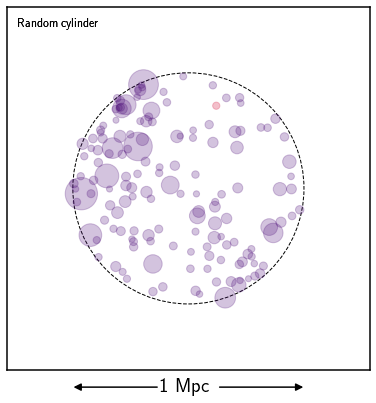

In [10]:
fig = plt.figure(figsize=(8/1.2,8/1.2))
ax = fig.add_subplot(111, aspect='equal')
 
cmap = matplotlib.cm.get_cmap('magma')
 
# ---- plot actual virial radius
circle1 = plt.Circle((0, 0), rradius, color='black', fill=False, linestyle='--')
ax.add_artist(circle1)
 
# ---- plot subhalos within cylinder of virial radius at x-face LOS
for i in range(len(rrad1x)):
    circleN = plt.Circle((rpos1x_y[i], rpos1x_z[i]), rrad1x[i], color=cmap(0.85), alpha=0.35)
    ax.add_artist(circleN)
# ---- plot subhalos within cylinder of [1-2] times virial radius at x-face LOS
for i in range(len(rrad2x)):
    circle2N = plt.Circle((rpos2x_y[i], rpos2x_z[i]), rrad2x[i], color=cmap(0.6), alpha=0.35)
    ax.add_artist(circle2N)
# ---- plot subhalos within cylinder of 2] times virial radius and box length x-face LOS
for i in range(len(rrad3x)):
    circle3N = plt.Circle((rpos3x_y[i], rpos3x_z[i]), rrad3x[i], color=cmap(0.25), alpha=0.25)
    ax.add_artist(circle3N)

# arrow outside box
ax.tick_params(axis=u'both', which=u'both', labelbottom='off', labelleft='off', length=0)
ax.set_xlim(-775,775)
ax.set_ylim(-775,775)
ax.text(-120, -870, '1 Mpc', fontsize=20)
ax.annotate('', xy=(-500, -850), xytext=(-125, -850), xycoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle="-|>", color='black', linewidth=1.5))
ax.annotate('', xy=(500, -850), xytext=(125, -850), xycoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle="-|>", color='black', linewidth=1.5))

 
# Additional text
from matplotlib.patches import Rectangle
empty = Rectangle((0,0), 0, 0, alpha=0.0)
label = ax.legend([empty],
         [r'Random cylinder'], loc="upper left", fontsize=12, frameon=False, handlelength=0, handletextpad=0)
label.get_texts()[0].set_color('black')
ax.add_artist(label)
plt.show()

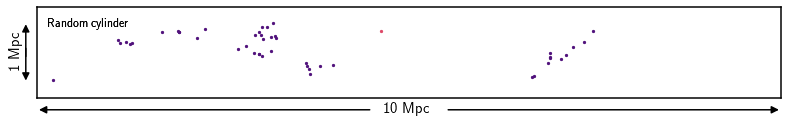

In [11]:
fig = plt.figure(figsize=(16/1.2,2/1.2))
ax = fig.add_subplot(111)
 
cmap = matplotlib.cm.get_cmap('magma')

ax.scatter(rpos1x_x, rpos1x_z, color=cmap(0.85), s=5)
ax.scatter(rpos2x_x, rpos2x_z, color=cmap(0.6), s=5)
ax.scatter(rpos3x_x, rpos3x_z, color=cmap(0.25), s=5)
 
ax.tick_params(axis=u'both', which=u'both', labelbottom='off', labelleft='off', length=0)
ax.set_xlim(-5000,5000)
ax.set_ylim(-750,750)
 
# horizontal arrow outside box
ax.text(-330, -1000, '10 Mpc', fontsize=15)
ax.annotate('', xy=(-5000, -950), xytext=(-500, -950), xycoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle="-|>", color='black', linewidth=1.5))
ax.annotate('', xy=(5000, -950), xytext=(500, -950), xycoords='data', annotation_clip=False,
             arrowprops=dict(arrowstyle="-|>", color='black', linewidth=1.5))
 
# horizontal arrow outside box
ax.text(-5400, 150, '1\ Mpc', rotation=90, fontsize=15)
ax.annotate('', xy=(-5150, -500), xytext=(-5150, 100), xycoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle="-|>", color='black', linewidth=1.5))
ax.annotate('', xy=(-5150, 500), xytext=(-5150, -100), xycoords='data', annotation_clip=False,
             arrowprops=dict(arrowstyle="-|>", color='black', linewidth=1.5))
 
# Additional text
from matplotlib.patches import Rectangle
empty = Rectangle((0,0), 0, 0, alpha=0.0)
label = ax.legend([empty],
         [r'Random cylinder'], loc="upper left", fontsize=12, frameon=False, handlelength=0, handletextpad=0)
label.get_texts()[0].set_color('black')
ax.add_artist(label)
plt.show()

***

***

***